second draft, gonna cut out the mass estimate and:

ignore everything without a mass
if no uncertainty on mass, ignore, 
maybe with radius - ignore too
can calc orbsmax with stellar mass and period
add in transit duration

In [1]:
#initial filtering code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Data/composite_exo_data-unfiltered.csv', comment='#')


# Functions to calculate equilibrium temperature and TSM
def calc_Teq(T_star, R_star, a_AU, A=0):
    """Calculates eq temp (assuming full heat redistribution)
    T_star : stellar temp in Kelvin
    R_star : stellar R in R_sun
    a_AU   : orbital semi-major axis [AU]
    A      : bond albedo (default 0)
    """
    a_Rsun = a_AU * 215.032  # need matching units
    return T_star * (R_star / (2*a_Rsun))**0.5 * (1 - A)**0.25

def calc_TSM(R_p, M_p, T_eq, R_star, mJ):
    """Calculates Transmission Spectroscopy Metric (TSM) from Kempton+2018
    R_p : planet radius (R_earth)
    M_p : planet mass (M_earth)
    T_eq: planet eq temp in K
    R_star: units of R_sun
    mJ  : J-band magnitude of host star 
    scale_factor: depends on planet size regime (See Kempton+2018 for some values)
    """

    SF = np.where(R_p < 1.5, 0.190,
        np.where(R_p < 2.75, 1.26, 1.28))
    
    TSM = (SF * (R_p**3 * T_eq) / (M_p * R_star**2) * 10**(-mJ/5))
    return TSM


In [3]:
### GENERAL FILTERING CODE 
# choose columns we want to keep 
useful_columns_only = df[['pl_name', 'pl_orbper', 'pl_orbsmax', 
                'pl_bmasse', 'pl_rade', 'pl_radelim', 'pl_radeerr1', 'pl_radeerr2',
                'pl_trandep', 'pl_trandur', 'pl_bmasselim', 'pl_bmasseerr2', 
                'pl_bmasseerr1', 'pl_orbeccen', 'pl_orbincl', 'st_rad', 
                'st_mass', 'st_teff', 'pl_ratror', 'st_met', 'st_metlim',
                'sy_jmag', 'discoverymethod','pl_controv_flag','st_logg',
                #adding columns tamzin used in her calcs
                'st_tefferr1', 'st_tefferr2',
                'st_raderr1',  'st_raderr2',
                'pl_orbsmaxerr1', 'pl_orbsmaxerr2',
                'sy_jmagerr1', 'sy_jmagerr2']]

default_planets = useful_columns_only.copy()

#remove planets with no mass or 0 uncertainty on mass or lim flag on mass
default_planets_m = default_planets[
    (default_planets['pl_bmasse'].notna()) &
    (default_planets['pl_orbsmax'].notna()) &
    (default_planets['pl_bmasseerr1'].notna()) &
    (default_planets['pl_bmasseerr2'].notna()) &
    (default_planets['pl_bmasseerr1'] != 0) &
    (default_planets['pl_bmasseerr2'] != 0) &
    (default_planets['pl_bmasselim'] == 0)
]

#remove planets with no radius or 0 uncertainty on radius or lim flag on radius
default_planets_mr = default_planets_m[
    (default_planets_m['pl_rade'].notna()) &
    (default_planets_m['pl_radeerr1'].notna()) &
    (default_planets_m['pl_radeerr2'].notna()) &
    (default_planets_m['pl_radeerr1'] != 0) &
    (default_planets_m['pl_radeerr2'] != 0) &
    (default_planets_m['pl_radelim'] == 0)
]

# remove planets that don't have the necessary parameters for team 1
filtered_planets = default_planets_mr[
    (default_planets_mr['st_rad'].notna()) &
    (default_planets_mr['st_mass'].notna()) &
    (default_planets_mr['st_teff'].notna()) &
    (default_planets_mr['sy_jmag'].notna()) &
    (default_planets_mr['st_met'].notna()) &
    (default_planets_mr['pl_controv_flag'].notna())
]




# filter for the data we need for uncertainty calculations
filtered_planets = filtered_planets[
    (filtered_planets['st_tefferr1'].notna()) & (filtered_planets['st_tefferr2'].notna()) &
    (filtered_planets['st_raderr1'].notna())  & (filtered_planets['st_raderr2'].notna()) &
    (filtered_planets['pl_orbsmaxerr1'].notna()) & (filtered_planets['pl_orbsmaxerr2'].notna()) &
    (filtered_planets['sy_jmagerr1'].notna()) & (filtered_planets['sy_jmagerr2'].notna()) &
    (filtered_planets['st_tefferr1'] != 0) & (filtered_planets['st_tefferr2'] != 0) &
    (filtered_planets['st_raderr1'] != 0)  & (filtered_planets['st_raderr2'] != 0) &
    (filtered_planets['pl_orbsmaxerr1'] != 0) & (filtered_planets['pl_orbsmaxerr2'] != 0) &
    (filtered_planets['sy_jmagerr1'] != 0) & (filtered_planets['sy_jmagerr2'] != 0)
]


# adding columns
# add mean errors
filtered_planets = filtered_planets.copy()

filtered_planets['pl_bmasseerr_avg'] = (
    filtered_planets['pl_bmasseerr1'].abs() + filtered_planets['pl_bmasseerr2'].abs()
) / 2
filtered_planets['pl_radeerr_avg'] = (
    filtered_planets['pl_radeerr1'].abs() + filtered_planets['pl_radeerr2'].abs()
) / 2
filtered_planets['st_tefferr_avg'] = (
    filtered_planets['st_tefferr1'].abs() + filtered_planets['st_tefferr2'].abs()
) / 2
filtered_planets['st_raderr_avg'] = (
    filtered_planets['st_raderr1'].abs() + filtered_planets['st_raderr2'].abs()
) / 2
filtered_planets['pl_orbsmaxerr_avg'] = (
    filtered_planets['pl_orbsmaxerr1'].abs() + filtered_planets['pl_orbsmaxerr2'].abs()
) / 2
filtered_planets['sy_jmagerr_avg'] = (
    filtered_planets['sy_jmagerr1'].abs() + filtered_planets['sy_jmagerr2'].abs()
) / 2


# Constants in cgs
G = 6.67430e-8   # cm^3 g^-1 s^-2
M_earth = 5.972e27  # g
R_earth = 6.371e8   # cm

# add planet gravity in cgs units (cm/s^2)
M_p = filtered_planets['pl_bmasse']
R_p = filtered_planets['pl_rade']

filtered_planets['g_planet_cgs'] = G * (M_p * M_earth) / ( (R_p * R_earth)**2 )

# Already computed g_planet_cgs
g = filtered_planets['g_planet_cgs']

# Mass and radius errors
M_err = filtered_planets['pl_bmasseerr_avg']
R_err = filtered_planets['pl_radeerr_avg']

# Fractional error
frac_g_err = np.sqrt( (M_err / filtered_planets['pl_bmasse'])**2 +
                      (2 * R_err / filtered_planets['pl_rade'])**2 )
# Absolute error in cm/s²
filtered_planets['g_planet_cgs_err'] = g * frac_g_err


# set size limits for filtering
radius_lower = 1.5 # earth radii
radius_upper = 4 

# filter for planets in size limits
filtered_sizes = filtered_planets[
    (filtered_planets['pl_rade'] >= radius_lower) &
    (filtered_planets['pl_rade'] <= radius_upper)
]

fs_with_Teq = filtered_sizes.copy()
fs_with_Teq['pl_Teq'] = calc_Teq(
    fs_with_Teq['st_teff'],
    fs_with_Teq['st_rad'],
    fs_with_Teq['pl_orbsmax'],
    A=0.3
)

#from tamzin's code for uncertainty calculation
#fractional error in Teq
frac_Teq_err = np.sqrt(
    (fs_with_Teq['st_tefferr_avg'] / fs_with_Teq['st_teff'])**2 +
    (0.5 * fs_with_Teq['st_raderr_avg'] / fs_with_Teq['st_rad'])**2 +
    (0.5 * fs_with_Teq['pl_orbsmaxerr_avg'] / fs_with_Teq['pl_orbsmax'])**2
)

fs_with_Teq['pl_Teq_err'] = fs_with_Teq['pl_Teq'] * frac_Teq_err


fs_with_TSM = fs_with_Teq.copy()
fs_with_TSM['pl_tsm'] = calc_TSM(
    fs_with_TSM['pl_rade'],
    fs_with_TSM['pl_bmasse'],
    fs_with_TSM['pl_Teq'],
    fs_with_TSM['st_rad'],
    fs_with_TSM['sy_jmag'],  # 2MASS J-mag
)


frac_TSM_err = np.sqrt(
    (3 * fs_with_TSM['pl_radeerr_avg'] / fs_with_TSM['pl_rade'])**2 +
    (fs_with_TSM['pl_Teq_err'] / fs_with_TSM['pl_Teq'])**2 +
    (fs_with_TSM['pl_bmasseerr_avg'] / fs_with_TSM['pl_bmasse'])**2 +
    (2 * fs_with_TSM['st_raderr_avg'] / fs_with_TSM['st_rad'])**2 +
    ((np.log(10) / 5) * fs_with_TSM['sy_jmagerr_avg'])**2
)

fs_with_TSM['pl_tsm_err'] = fs_with_TSM['pl_tsm'] * frac_TSM_err
planets = fs_with_TSM.copy()
# planets.to_csv('filtered_exoplanets.csv', index=False)   

In [ ]:
# checks
print('initial downloaded table dimensions:', df.shape ,'\nand dimensions after filtering for usable:')
print('column:', useful_columns_only.shape)
print('mass:', default_planets_m.shape)
print('radius:', default_planets_mr.shape)
print('desired parameters:', default_planets_mr.shape)
print('size:', filtered_sizes.shape)
#fs_with_TSM[['pl_name','pl_rade','pl_bmasse','pl_Teq','st_rad','sy_jmag','pl_tsm']].head()

initial downloaded table dimensions: (6080, 145) 
and dimensions after filtering for usable:
column: (6080, 32)
mass: (2820, 32)
radius: (1436, 32)
desired parameters: (1436, 32)
size: (379, 40)


In [4]:
planets.to_csv('planets.csv', index=False)

##### Initial TSM histogram
Well that narrows it down a bit. Archie notes - paper describes 300 high quality targets over large radius (inc > R_nep), and we have 300 of any quality. Maybe histogram the TSM?


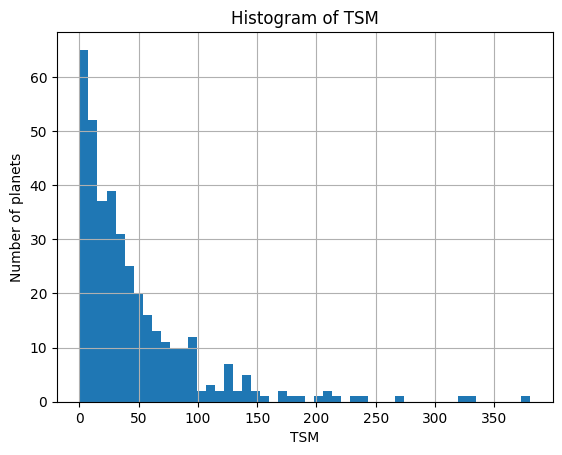

In [6]:
import matplotlib.pyplot as plt

fs_with_TSM['pl_tsm'].hist(bins=50) 
plt.xlabel('TSM')
plt.ylabel('Number of planets')
plt.title('Histogram of TSM')
plt.show()
# checked and this ignores NaNs automatically

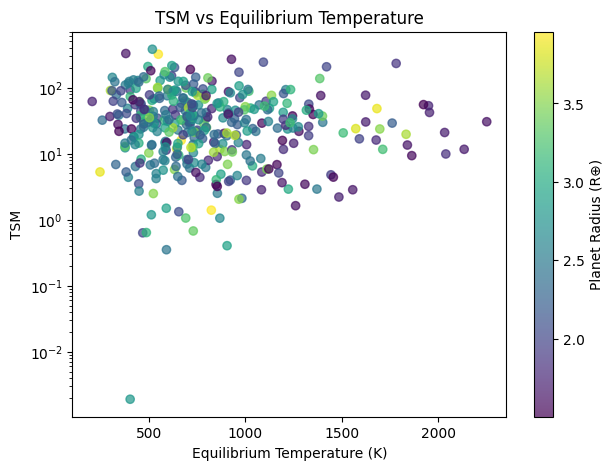

In [7]:

plt.figure(figsize=(7,5))
sc = plt.scatter(
    fs_with_TSM['pl_Teq'],
    fs_with_TSM['pl_tsm'],
    c=fs_with_TSM['pl_rade'],
    cmap='viridis',
    alpha=0.7
)
plt.yscale('log')
plt.xlabel('Equilibrium Temperature (K)')
plt.ylabel('TSM')
plt.title('TSM vs Equilibrium Temperature')
cbar = plt.colorbar(sc)
cbar.set_label('Planet Radius (R⊕)')
plt.show()


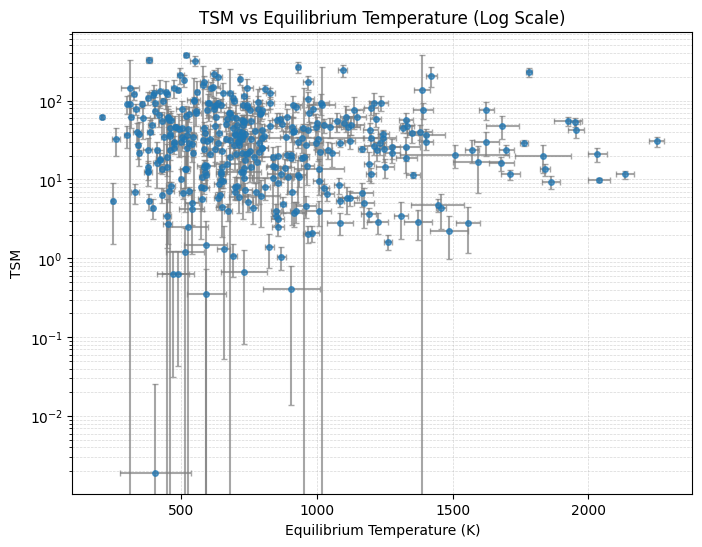

In [8]:
# Plotting TSM vs equilibrium temperature to check it looks reasonable
plt.figure(figsize=(8,6))
plt.errorbar(
    planets['pl_Teq'], 
    planets['pl_tsm'], 
    xerr=planets['pl_Teq_err'], 
    yerr=planets['pl_tsm_err'], 
    fmt='o', 
    ecolor='gray', 
    alpha=0.7, 
    markersize=4, 
    capsize=2
)
plt.xlabel("Equilibrium Temperature (K)")
plt.ylabel("TSM")
plt.title("TSM vs Equilibrium Temperature (Log Scale)")
plt.yscale("log")
plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.5)
plt.show()


In [9]:
# checks
print('initial downloaded table dimensions:', df.shape ,'\nand dimensions after filtering for usable:')
print('column:', useful_columns_only.shape)
print('mass:', default_planets_m.shape)
print('radius:', default_planets_mr.shape)
print('desired parameters:', default_planets_mr.shape)
print('size:', filtered_sizes.shape)
#fs_with_TSM[['pl_name','pl_rade','pl_bmasse','pl_Teq','st_rad','sy_jmag','pl_tsm']].head()

initial downloaded table dimensions: (6080, 145) 
and dimensions after filtering for usable:
column: (6080, 32)
mass: (2820, 32)
radius: (1436, 32)
desired parameters: (1436, 32)
size: (379, 40)


In [27]:
# row with maximum Teq
max_row = planets.loc[planets['pl_Teq'].idxmax()]


print("Max Teq value:", max_row['pl_Teq'])

# row with minimum Teq
min_row = planets.loc[planets['pl_Teq'].idxmin()]

print("Min Teq value:", min_row['pl_Teq'])


Max Teq value: 2252.5604239426766
Min Teq value: 206.29545979302452


In [29]:
find_row = planets[planets['pl_name'] == 'Kepler-51 b']
print(find_row)

Empty DataFrame
Columns: [pl_name, pl_orbper, pl_orbsmax, pl_bmasse, pl_rade, pl_radelim, pl_radeerr1, pl_radeerr2, pl_trandep, pl_trandur, pl_bmasselim, pl_bmasseerr2, pl_bmasseerr1, pl_orbeccen, pl_orbincl, st_rad, st_mass, st_teff, pl_ratror, st_met, st_metlim, sy_jmag, discoverymethod, pl_controv_flag, st_tefferr1, st_tefferr2, st_raderr1, st_raderr2, pl_orbsmaxerr1, pl_orbsmaxerr2, sy_jmagerr1, sy_jmagerr2, pl_bmasseerr_avg, pl_radeerr_avg, st_tefferr_avg, st_raderr_avg, pl_orbsmaxerr_avg, sy_jmagerr_avg, g_planet_cgs, g_planet_cgs_err, pl_Teq, pl_Teq_err, pl_tsm, pl_tsm_err]
Index: []

[0 rows x 44 columns]


In [ ]:
sorted_teq = planets.sort_values(by='g_planet_cgs', ascending=True)
sorted_teq.head(10)


# planets.plot(x='pl_Teq', y='pl_tsm', kind='scatter')  # scatter plot

# plt.xlabel('pl_Teq')  # optional: label x-axis
# plt.ylabel('pl_tsm')  # optional: label y-axis
# plt.title('pl_tsm vs pl_Teq')  # optional: add title
# plt.show()


In [12]:
#test to see which planets are missing semi major axis errors 
mask = (
    filtered_sizes['pl_orbsmax'].isna() | (filtered_sizes['pl_orbsmax'] == 0) |
    filtered_sizes['pl_orbsmaxerr2'].isna() | (filtered_sizes['pl_orbsmaxerr2'] == 0)
)

missing_orbsmaxerr_planets = filtered_sizes.loc[mask, 'pl_name'].tolist()

# print the list
print(missing_orbsmaxerr_planets)

# (optional) see the actual err values too
print(filtered_sizes.loc[mask, ['pl_name','pl_orbsmax','pl_orbsmaxerr1','pl_orbsmaxerr2']].head(71))

[]
Empty DataFrame
Columns: [pl_name, pl_orbsmax, pl_orbsmaxerr1, pl_orbsmaxerr2]
Index: []


In [13]:
print(filtered_planets[['pl_orbsmaxerr1','pl_orbsmaxerr2']].dtypes)


pl_orbsmaxerr1    float64
pl_orbsmaxerr2    float64
dtype: object


In [14]:
for c in ['pl_orbsmaxerr1','pl_orbsmaxerr2']:
    filtered_planets[c] = pd.to_numeric(filtered_planets[c], errors='coerce')

mask_pass = (
    filtered_planets['pl_orbsmaxerr1'].notna() &
    filtered_planets['pl_orbsmaxerr2'].notna() &
    (filtered_planets['pl_orbsmaxerr1'] != 0) &
    (filtered_planets['pl_orbsmaxerr2'] != 0)
)

print(filtered_planets.shape[0], mask_pass.sum(), filtered_planets.shape[0] - mask_pass.sum())


1284 1284 0


In [7]:

df2 = pd.read_csv('Data/selected_planets_full_table_withg_star.csv', comment='#')

In [11]:
print(df2.columns)
df2_new = df2.drop(columns=['Teq_bin'])

Index(['pl_name', 'pl_orbper', 'pl_orbsmax', 'pl_bmasse', 'pl_rade',
       'pl_radelim', 'pl_radeerr1', 'pl_radeerr2', 'pl_trandep', 'pl_trandur',
       'pl_bmasselim', 'pl_bmasseerr2', 'pl_bmasseerr1', 'pl_orbeccen',
       'pl_orbincl', 'st_rad', 'st_mass', 'st_teff', 'pl_ratror', 'st_met',
       'st_metlim', 'sy_jmag', 'discoverymethod', 'pl_controv_flag', 'st_logg',
       'st_tefferr1', 'st_tefferr2', 'st_raderr1', 'st_raderr2',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'sy_jmagerr1', 'sy_jmagerr2',
       'pl_bmasseerr_avg', 'pl_radeerr_avg', 'st_tefferr_avg', 'st_raderr_avg',
       'pl_orbsmaxerr_avg', 'sy_jmagerr_avg', 'g_planet_cgs',
       'g_planet_cgs_err', 'pl_Teq', 'pl_Teq_err', 'pl_tsm', 'pl_tsm_err',
       'pl_eqt_calc', 'pl_eqt_calc_err', 'TSM', 'TSM_err', 'Teq_bin'],
      dtype='object')


In [12]:
df2_new.to_csv('selected_planets_less_words.csv', index=False)

In [13]:
planets2 = planets.copy()

In [ ]:
# Separating into temperature bins
temp_bins = [0, 500, 800, 1100, 1400, 1700, np.inf]
bin_labels = [
    "Cool (<500 K)",
    "Warm (500–800 K)",
    "Hot (800–1100 K)",
    "Very hot (1100–1400 K)",
    "Extremely hot (1400–1700 K)",
    "Hottest (>1700 K)"
]

overwrite = True

# Putting planets into their bins
planets2["Teq_bin"] = pd.cut(
    planets2["pl_Teq"],
    bins=temp_bins,
    labels=bin_labels,
    right=False  # includes lower end, excludes upper, so 500K would go into 'Warm', not 'Cool'
)

# How many top-TSM planets sampled per temperature bin
# Can be changed depending on what we need!!!!!
N_sample_per_bin = 5

# Selecting the highest TSMs
highest_TSM_per_bin = (
    planets2
    .dropna(subset=["Teq_bin"])   # safety check
    .sort_values("pl_tsm", ascending=False)
    .groupby("Teq_bin")
    .head(N_sample_per_bin)
)

# Only keeping relevant columns in selection_table
selection_table = highest_TSM_per_bin[
    ["pl_name", "pl_eqt_calc", "pl_eqt_calc_err", "TSM", "TSM_err", "Teq_bin", "pl_trandur"]
].sort_values(["Teq_bin", "TSM"], ascending=[True, False])

key_col = "pl_name"

selected_full = planets2[planets2[key_col].isin(selection_table[key_col])].copy()

output_file = "/content/drive/MyDrive/Y3 Exoplanet Group Study/selected_planets_full_table.csv"


selected_full.to_csv(output_file, index=False)

print(f"\nSaved {len(selected_full)} planets to {output_file}\n")

selection_table

In [ ]:
def select_top_planets(df, temp_col="pl_Teq", tsm_col="pl_tsm", top_n=5, key_col="pl_name"):
    """
    top_n = number per bin
    returns:
        selection_table: top N planets per bin with selected columns
        selected_full: full original rows of selected planets
    """
    df = df.copy()
    
    # Define temperature bins and labels
    temp_bins = [0, 500, 800, 1100, 1400, 1700, np.inf]
    bin_labels = [
        "Cool (<500 K)", "Warm (500–800 K)", "Hot (800–1100 K)",
        "Very hot (1100–1400 K)", "Extremely hot (1400–1700 K)", "Hottest (>1700 K)"
    ]
    
    # Add temperature bin column
    df["Teq_bin"] = pd.cut(df[temp_col], bins=temp_bins, labels=bin_labels, right=False)
    
    # Sort by TSM descending
    df_sorted = df.sort_values(tsm_col, ascending=False)
    
    # Take top N per temperature bin
    top_per_bin = df_sorted.groupby("Teq_bin").head(top_n)
    
    # Keep only relevant columns for selection table
    selection_columns = [
        key_col, "pl_Teq", "pl_Teq_err",
        "pl_tsm", "pl_tsm_err", "Teq_bin", "pl_trandur"
    ]
    selection_table = top_per_bin[selection_columns] \
                        .sort_values(["Teq_bin", "pl_tsm"], ascending=[True, False])
    
    # Get full rows for selected planets
    selected_full = df[df[key_col].isin(selection_table[key_col])].copy()
    
    return selection_table, selected_full


# =========================
# Usage
# =========================

N_sample_per_bin = 5
selection_table, selected_full = select_top_planets(planets2, top_n=N_sample_per_bin)


# Optional: view selection table
selection_table


C:\Users\Stan\AppData\Local\Temp\ipykernel_22908\411408073.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_per_bin = df_sorted.groupby("Teq_bin").head(top_n)


,pl_name,pl_Teq,pl_Teq_err,pl_tsm,pl_tsm_err,Teq_bin,pl_trandur
4856,L 98-59 d,380.657929,9.834607,327.812499,32.623315,Cool (<500 K),0.840000
861,HD 191939 d,495.301554,12.926390,208.188340,48.156343,Cool (<500 K),5.360000
5434,TOI-2443 b,473.048917,10.423446,145.334194,36.213166,Cool (<500 K),4.548000
282,GJ 414 A b,310.843346,33.650109,142.609333,184.180076,Cool (<500 K),NaN
5350,TOI-2015 b,485.851021,4.288490,136.622917,6.440520,Cool (<500 K),0.987600
213,GJ 1214 b,518.405172,7.993180,380.584758,23.734691,Warm (500–800 K),0.869660
54,AU Mic b,549.267382,16.382580,319.920753,48.874841,Warm (500–800 K),3.492700
664,HD 136352 c,619.417696,12.505974,214.891130,31.558853,Warm (500–800 K),3.251000
242,GJ 3090 b,633.297409,16.097027,201.591027,55.229548,Warm (500–800 K),1.281000
959,HD 219134 c,715.396182,5.515620,188.393048,30.140047,Warm (500–800 K),1.660000


In [ ]:
# remove extra columns with words
selected_full = selected_full.drop(columns=['discoverymethod','Teq_bin'])

# Save full table
output_file = "selected_planets_full_table.csv"
selected_full.to_csv(output_file, index=False)
print(f"Saved {len(selected_full)} planets to {output_file}")


Saved 30 planets to selected_planets_full_table.csv
